### Notebook for analysing nf pipeline output

#### Sequencing batch 14

### Sequencing information 
 - Analysis no.: A008
 - Platform: Illumina MiSeq
 - Library preparion: NEBNext/NEBNext FS
 - Loaded: pM
 - Seq Date: 28-08-2021
 - Number of samples:96
 - Cluster Density: 1134K
 - Passing Filter: 86.3/88.4
 - Output: 7.421G/6.6G
 - Fragment size: 250/550
 - Lib conc: 
 - Cubit 
 - Lib load start concentration: nM
 - Cyles: 200
 - PhiX: False

In [ ]:
# plot primer depths across samples-GK
import pandas as pd, matplotlib.pyplot as plt, numpy as np, os

suffix = '.amplicon.regions.coverage.tsv'
base_dir = '/home/douso/2021-08-30_run14_miseq/dpt'
files = os.listdir(f'{base_dir}')
data = []
for file in files:
    if file.endswith(suffix):
        data.append(file)
    else: pass
a = len(data)
b, c = 1, -1
fig, axs = plt.subplots(a, b, figsize=(20,180)) 

xtick = np.arange(0, 98)
xlabel = np.arange(1, 99)

for file in data:
    c += 1
    sample_name = file.split('_')[0]
    sample_df = pd.read_table(f'{base_dir}/{file}')
    sample_df2 = sample_df[['region', 'coverage']]
    sample_df2.plot(logy=True, ax=axs[c], sharex=True, sharey=False) 
    axs[c].legend([sample_name], loc='lower left')
plt.xlabel('Primer name')
plt.ylabel('Read coverage')
plt.xticks(xtick, xlabel, rotation=45)
plt.tight_layout()
plt.show()
#fig.savesample_df2fig('avg_kit_coverage2.png')


In [ ]:
# plot read depths-GK
import pandas as pd, numpy as np, os, matplotlib.pyplot as plt
base_dir = '/home/douso/2021-08-30_run14_miseq/dpt'
suffix = '.genome.regions.coverage.tsv'
files = os.listdir(f'{base_dir}')
data = []
for file in files:
    if file.endswith(suffix):
        data.append(file)
    else: pass
a = len(data)
b, c = 1, -1

fig, axs = plt.subplots(a, b, figsize=(20, 180))

xtick = range(0, 30200, 200)

for file in data:
    c += 1
    sample_name = file.split('_')[0]
    try:
        df1 = pd.read_table(f'{base_dir}/{file}')
        d = df1['coverage'].to_frame()
        d.set_index(np.arange(0, 30000, 200)).plot(logy=True, ax=axs[c], sharex=True, color='orange')
        axs[c].legend([sample_name], loc='lower left')
        text = file.split('_')[1]
        plt.ylabel('Read coverage')
    except TypeError:
            print(f'no numeric data to plot for {file}')
    finally: pass
plt.xlabel('Genome position')
plt.xticks(xtick, rotation=90)
plt.tight_layout()
plt.show()
#fig.savefig('avg_kit_coverage.png')

## Packages

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
import glob

In [16]:
base_dir = '/home/douso/2021-08-10_run13_nextseq/'
batch = 'seq14'
# dpt_dir = # ivar, samtools-depth output files
# nxt_dir = # nextclade .tsv output file
# png_dir = # pangolin .tsv output file
# var_dir = # snpEff ouput
# rmd_dir = # raw metadata - moh .xlsx spread sheet
#dpt var nxt png

### Sequencing information 
 - Analysis no.: NF-008 (batch 14)
 - Platform: Illumina MiSeq
 - Library preparion: NEBNext/NEBNext FS
 - Seq Date: MiSeq (28-08-2021)
 - Number of samples: 96
 - Sample summ: COVCs (Kisumu, HB)
 - VC pipeline: nextflow-viralcon, 

## Functions

In [17]:
# define a func to replace spaces in the header names
def tidy_header(df):
    df.columns = [col.replace(' ', '_') for col in df.columns]
    return df

In [18]:
# define func to retrieve particular columns from a df (spaces in col names must be replaced with _ in the input col_list)
def get_cols(df, col_list):
    new_df = tidy_header(df)
    return new_df[col_list]

In [19]:
# define a function to replace from a dictionary ('key is what is to be replaced': 'value is the replacement')
def replace(string, substitutions):
    substrings = sorted(substitutions, key=len, reverse=True)
    regex = re.compile('|'.join(map(re.escape, substrings)))
    return regex.sub(lambda match: substitutions[match.group(0)], string)

In [20]:
# define function to merge variants and nextclade data
def merge_varNxt(df_var_cln, df_nxt_cln):
    return (df_var_cln.set_index('sample_name').merge(df_nxt_cln
          .set_index('seqName'), how='outer', left_index=True, right_index=True)
                 .reset_index().rename(columns={'index': 'sample_name'}))

In [21]:
# define function to merge pangolin and variants-nextclade data
def merge_pngVxt(df_png_cln, df_varNxt):
    return (df_png_cln.set_index('Sequence_name').merge(df_varNxt
        .set_index('sample_name'), how='outer', left_index=True, right_index=True)
            .reset_index().rename(columns={'index': 'Sequence_name'}))


In [22]:
# define function to merge metadata with cts data
def merge_rmdCts(df_rmd_cln, df_cts_cln):
    return (df_rmd_cln.set_index('S_NUM').merge(df_cts_cln.set_index('Sample_Name'), how='outer', left_index=True, right_index=True)
            .reset_index().rename(columns={'index': 'S_NUM'}))


In [23]:
# define function to merge metadata and seq data
def merge_vnpPmd(df_pngVxt, df_rmdCts):
    return (df_pngVxt.set_index('S_NUM')
            .merge(df_rmdCts.set_index('S_NUM'), how='left', left_index=True, right_index=True)
                 .reset_index().rename(columns={'index': 'S_NUM'}))

In [24]:
# define a function to retrieve MoC and all mutations for the s-gene
def get_mut_of_concern(ann_file_name, moc_list):

    def intersection(x, y):
        return list(set(x) & set(y))

    moc_list = moc_list
#     file_name = 'k-per-gene_variant_anns.tsv'
    df = ann_file_name[['sample_name','S']]

#     df = pd.read_table(f'{base_dir}/{file_name}')[['sample_name','S']]
    mutations = []
    moc = []
    sample_id = []
    for row in df.itertuples():
        if isinstance(row.S, str):
            sgene = row.S
        else: 
            sgene = str(row.S)
        substitutions = sgene.replace(' ', '').split(',')[1:-1]
        if len(moc_list) >= len(intersection(moc_list, substitutions)) > 0:
            intsct = intersection(moc_list, substitutions)
            sample_name = row.sample_name
            mutations.append(str(substitutions).replace("[", "").replace("]", "").replace("'", ""))
            moc.append(str(intsct).replace("[", "").replace("]", "").replace("'", ""))
            sample_id.append(sample_name)
        else: pass 
    df = pd.DataFrame({'Sample_ID': sample_id, 'Mut_of_Concern_(S)': moc, 'All_Mutations_(S)': mutations})
    df_fnl = df.assign(Sample_ID = df['Sample_ID'].apply(lambda x: x.split('.')[0]))
    return df_fnl

### Variants data

In [25]:
# import the collated file for all the snpEff outputs
df_var = pd.read_table(f'{base_dir}/var/k-per-gene_variant_anns.tsv')
df_var_fnl = df_var.assign(sample_name = df_var['sample_name'].apply(lambda x: '_'.join(x.split('_')[:-1]) if (len(x.split('_')) > 2) else x.split('_')[0]))

In [26]:
df_var_fnl#.head()

,sample_name,num_vars,ORF1ab,ORF1a,S,ORF3a,ORF3b,E,M,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10
0,COVC23642,34,"C1103C, T1682I, A1708D, F1907F, D3526E, Y4080f...",NaN,"H69_V70del, D138H, Y145del, F490S, N501Y, A570...",NaN,NaN,NaN,F53F,NaN,NaN,NaN,"Q27*, R52I, Y73C","D3H, D3V, D3E, R203K, R203R, G204R, S235F, D341D",NaN,NaN,NaN
1,COVC21366,11,"T265I, F924F, L4715L, K6761E",NaN,"Y145del, D614G, L841L","A23V, Q57H",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"S186F, R195K",NaN,NaN,NaN
2,COVC19574,12,"T265I, F924F, G3757G, L4715L, S6188F",NaN,"Y145del, D614G, L841L","A23V, Q57H",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"S186F, R195K",NaN,NaN,NaN
3,KEMRI_02_93127,32,"R24R, S216S, S248S, F924F, T1001I, A1708D, F19...",NaN,"H69_V70del, Y145del, A570D, D614G, P681H, T716...","V201fs, D250V",NaN,NaN,H125Y,NaN,NaN,NaN,"Q27*, R52I, K68*, Y73C","D3H, D3V, D3E",NaN,NaN,NaN
4,COVC23473,36,"S216S, N615N, L766L, F924F, T1001I, A1708D, F1...",NaN,"H69_V70del, Y145del, N501Y, A570D, D614G, P681...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Q27*, R52I, K68*, Y73C","D3H, D3V, D3E, R203K, R203R, G204R, S235F",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,COVC23694,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
380,COVC23745,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
381,KEMRI_01_90722,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
382,COVG023,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Nextclade data

In [27]:
# import Nextclade clade data
df_nxt = pd.read_table(f'{base_dir}/nxt/nxt.tsv')

# retrieve cols seqName and clade (func get_cols replaces col name spaces with _)
cols = ['seqName', 'clade', 'totalMissing']
df_nxt_cln = get_cols(df_nxt, cols)
coverage = round(100 - (df_nxt_cln['totalMissing'] / 29903) * 100, 1)
df_nxt_cln1 = df_nxt_cln.assign(seqName = df_nxt_cln['seqName'].apply(lambda x: '_'.join((x.split('.')[0]).split('_')[1:-1]) if (len(x.split('_')) > 2) else (x.split('.')[1]).split('_')[0]))
df_nxt_fnl = df_nxt_cln1.assign(coverage = coverage).drop('totalMissing', axis=1)

In [28]:
df_nxt_fnl#.head()

,seqName,clade,coverage
0,COVC18535,20B,61.3
1,COVC19452,20C,92.5
2,COVC19458,20A,71.5
3,COVC19336,20A,96.0
4,COVC19473,20A,90.0
...,...,...,...
373,KEMRI_02_93544,20A,98.7
374,KEMRI_02_92919,"20I (Alpha, V1)",96.5
375,KEMRI_02_93645,"20I (Alpha, V1)",84.2
376,KEMRI_02_93806,"20I (Alpha, V1)",94.3


### Pangolin data v.3.0.5 (05-06-2021) Ran: 17-06-2021

In [29]:
# import Pangolin lineage data
df_png = pd.read_csv(f'{base_dir}/png/png.csv', header=0)
# base_dir_pango = '/home/ouso/nextclade_files/batch2/nextclade_files_04-04-2021_11:25'
# file_name_pango = 'consensus_pango.xlsx'

# df_png = pd.read_excel(f'{base_dir_pango}/{file_name_pango}')
months = {'January': 'Jan', 'February': 'Feb', 'March': 'Mar',
         'April': 'Apr', 'June': 'Jun', 'July': 'Jul', 'August': 'Aug',
          'September': 'Sep', 'October': 'Oct', 'November': 'Nov', 'December': 'Dec'}
# retrieve cols Sequence_name and Lineage (func get_cols replaces col names spaces with _)
cols = ['Sequence_name', 'Lineage', 'Scorpio_call']#, 'Most_common_countries']
df_png_cln = get_cols(tidy_header(df_png), cols)
df_png_fnl = df_png_cln.assign(Sequence_name = df_png_cln['Sequence_name'].apply(lambda x: '_'.join(x.split('_')[:-1]) if (len(x.split('_')) > 2) else x.split('_')[0]))
# df_png_fnl = df_png_cln1.assign(Date_range=df_png_cln1['Date_range'].apply(lambda x: replace(x, months) if (isinstance(x, str)) else x))

In [30]:
df_png_fnl#.head()

,Sequence_name,Lineage,Scorpio_call
0,COVC18546,B.1,NaN
1,COVC18558,B.1,NaN
2,COVC18572,B.1,NaN
3,COVC18941,B.1,NaN
4,COVC18948,B.1,NaN
...,...,...,...
265,KEMRI_02_93550,B.1.530,NaN
266,KEMRI_02_93645,B.1.1.7,Alpha (B.1.1.7-like)
267,KEMRI_02_93781,B.1.1.7,Alpha (B.1.1.7-like)
268,KEMRI_02_93792,B.1,NaN


# Metadata

In [31]:
# import raw metadata file
import pandas as pd
mbase_dir = '/home/douso/Documents/TrendData/Results/ResultsMerged'
df_rmd_cln = pd.read_excel(f'{mbase_dir}/COVID19-results-merged-cln.xlsx')

In [32]:
df_rmd_cln.head()

,S_NUM,AGE_YRS,GEND,OCCU,NAT,COUNT_RES,S_COUNT_RES,TRAV_HIST,TRAV_FROM,QUAR_PLACE,SYMPS,DT_SAM_COLL,DT_SAM_RECEP,RESULT,DT_CONF
0,COVC00001,35.0,F,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaT,NaT,Negative,2020-06-02
1,COVC00002,29.0,M,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaT,NaT,Negative,2020-06-02
2,COVC00003,50.0,M,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaT,NaT,Negative,2020-06-02
3,COVC00004,35.0,F,Casual,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaT,NaT,Negative,2020-06-02
4,COVC00005,27.0,F,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaT,NaT,Negative,2020-06-02


### Ct data

In [33]:
# import Ct data from sheet2 of the metadata file
ctbase_dir = '/home/douso/Documents/RunSheets/Cts'
df_cts = pd.read_excel(f'{ctbase_dir}/runsheet-cts.xlsx')

In [34]:
df_cts.head()

,Sample_Name,Well_Position,Dt_Run,Ct_Mean
0,COVC00137,D9,2020-06-03 17:04:05,37.6
1,COVC00154,F2,2020-06-03 17:04:05,35.2
2,COVC00744,D1,2020-06-12 18:14:45,34.7
3,COVC00762,E7,2020-06-12 18:14:45,36.0
4,COVC00767,E12,2020-06-12 18:14:45,34.1


### **Combining data**

#### Merge Variants and Nextclade data

In [35]:
# merge the nextclade data to the pangolin data
df_varNxt = merge_varNxt(df_var_fnl, df_nxt_fnl)

In [36]:
df_varNxt.head()

,sample_name,num_vars,ORF1ab,ORF1a,S,ORF3a,ORF3b,E,M,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10,clade,coverage
0,COVC18535,8.0,"F924F, L4715L, C5557F, I5747T",NaN,NaN,W69S,NaN,NaN,"T9T, L57L",NaN,NaN,NaN,S69P,NaN,NaN,NaN,NaN,20B,61.3
1,COVC18546,20.0,"L61L, E102Q, T265I, Y717Y, F924F, P926P, N3291...",NaN,"D614G, Q836Q,","L41L, Q57H",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"P13S, R195K, P207T, L353L",NaN,NaN,NaN,20C,90.5
2,COVC18558,15.0,"T265I, F924F, P2046T, P2685P, L4715L, E5390G, ...",NaN,"L54F, E484Q, D614G, I1225V","Q57H, T223I",NaN,NaN,NaN,NaN,NaN,NaN,NaN,R195K,NaN,NaN,NaN,20C,95.2
3,COVC18572,17.0,"T265I, F924F, A2470A, A3726S, L4715L, L5198L, ...",NaN,D614G,"Q57H, Q70H, L94L",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"S37P, F53F, S186F, R195K",NaN,NaN,NaN,20C,95.6
4,COVC18866,7.0,samples,skipped,since,they,failed,Bowtie2,1000,mapped,re,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Merge pango and var-nextclade data

In [37]:
# merge the variants-nextclade data to the pangolin data (prioritise pango - left join)
df_pngVxt = merge_pngVxt(df_png_fnl, df_varNxt)

In [38]:
df_pngVxt.head()

,Sequence_name,Lineage,Scorpio_call,num_vars,ORF1ab,ORF1a,S,ORF3a,ORF3b,E,...,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10,clade,coverage
0,COVC18535,NaN,NaN,8.0,"F924F, L4715L, C5557F, I5747T",NaN,NaN,W69S,NaN,NaN,...,NaN,NaN,NaN,S69P,NaN,NaN,NaN,NaN,20B,61.3
1,COVC18546,B.1,NaN,20.0,"L61L, E102Q, T265I, Y717Y, F924F, P926P, N3291...",NaN,"D614G, Q836Q,","L41L, Q57H",NaN,NaN,...,NaN,NaN,NaN,NaN,"P13S, R195K, P207T, L353L",NaN,NaN,NaN,20C,90.5
2,COVC18558,B.1,NaN,15.0,"T265I, F924F, P2046T, P2685P, L4715L, E5390G, ...",NaN,"L54F, E484Q, D614G, I1225V","Q57H, T223I",NaN,NaN,...,NaN,NaN,NaN,NaN,R195K,NaN,NaN,NaN,20C,95.2
3,COVC18572,B.1,NaN,17.0,"T265I, F924F, A2470A, A3726S, L4715L, L5198L, ...",NaN,D614G,"Q57H, Q70H, L94L",NaN,NaN,...,NaN,NaN,NaN,NaN,"S37P, F53F, S186F, R195K",NaN,NaN,NaN,20C,95.6
4,COVC18866,NaN,NaN,7.0,samples,skipped,since,they,failed,Bowtie2,...,mapped,re,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
df_pngVxt_cols = ['Sequence_name', 'Lineage', 'Scorpio call',
       'num_vars', 'ORF1ab', 'ORF1a', 'S', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6',
       'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10', 'clade',
       'coverage']
df_pngVxt_cols_rename = ['S_NUM', 'LIN', 'SCORP_CALL',
       'N_VAR', 'ORF1ab', 'ORF1a', 'S', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6',
       'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10', 'CLADE',
       'G_COV']
df_pngVxt.columns = df_pngVxt_cols_rename

#### Merge the metadata and Cts data

In [40]:
# merge metadata with cts data
df_rmdCts = merge_rmdCts(df_rmd_cln, df_cts).rename(columns={'Ct_Mean': 'AVG_Ct'})

In [41]:
df_rmdCts.head()

,S_NUM,AGE_YRS,GEND,OCCU,NAT,COUNT_RES,S_COUNT_RES,TRAV_HIST,TRAV_FROM,QUAR_PLACE,SYMPS,DT_SAM_COLL,DT_SAM_RECEP,RESULT,DT_CONF,Well_Position,Dt_Run,AVG_Ct
0,COVC00001,35.0,F,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaT,NaT,Negative,2020-06-02,NaN,NaT,NaN
1,COVC00002,29.0,M,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaT,NaT,Negative,2020-06-02,NaN,NaT,NaN
2,COVC00003,50.0,M,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaT,NaT,Negative,2020-06-02,NaN,NaT,NaN
3,COVC00004,35.0,F,Casual,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaT,NaT,Negative,2020-06-02,NaN,NaT,NaN
4,COVC00005,27.0,F,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaT,NaT,Negative,2020-06-02,NaN,NaT,NaN


#### Merge sequence/var-nxt-png (pngVxt) and  processed metadata (rmdCts)

In [42]:
# merge processed metadata with seq data
df_vnpPmd = merge_vnpPmd(df_pngVxt, df_rmdCts)

In [43]:
df_vnpPmd.columns#shape#head()

Index(['S_NUM', 'LIN', 'SCORP_CALL', 'N_VAR', 'ORF1ab', 'ORF1a', 'S', 'ORF3a',
       'ORF3b', 'E', 'M', 'ORF6', 'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF9a',
       'ORF9b', 'ORF10', 'CLADE', 'G_COV', 'AGE_YRS', 'GEND', 'OCCU', 'NAT',
       'COUNT_RES', 'S_COUNT_RES', 'TRAV_HIST', 'TRAV_FROM', 'QUAR_PLACE',
       'SYMPS', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'RESULT', 'DT_CONF',
       'Well_Position', 'Dt_Run', 'AVG_Ct'],
      dtype='object')

#### QC whether all samples sequenced had metadata

In [44]:
codes_fnl = set(df_vnpPmd['S_NUM'])
codes_metadata = set(df_rmdCts['S_NUM'])
codes_union = codes_fnl & codes_metadata
if codes_fnl - codes_union == {}:
    print('All the samples in the the analysis were in the pre-seq metadata')
else:
    print(f'The following samples may be lacking pre-seq metadata, please verify:\n{codes_fnl - codes_union}')
    

The following samples may be lacking pre-seq metadata, please verify:
{'COVG023', 'COVG028', 'Undetermined', 'COVG024', 'COVG019', 'COVG020', 'COVG027'}


#### Re-order df_vnpPmd columns and export merged metadata and sequencing data

In [45]:
header_MS = ['S_NUM', 'AGE_YRS', 'GEND', 'OCCU', 'NAT', 'COUNT_RES', 'TRAV_HIST',
               'TRAV_FROM', 'QUAR_PLACE', 'SYMPS', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'RESULT', 
               'DT_CONF', 'AVG_Ct', 'LIN', 'SCORP_CALL', 'CLADE', 'G_COV', 'N_VAR',
               'S', 'ORF1ab', 'ORF1a', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6', 'ORF7a', 'ORF7b', 
               'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10']

In [46]:
header_policy = ['S_NUM', 'AGE_YRS', 'GEND', 'OCCU', 'NAT', 'COUNT_RES', 'TRAV_HIST',
               'TRAV_FROM', 'QUAR_PLACE', 'SYMPS', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'RESULT', 
               'DT_CONF', 'AVG_Ct']

In [47]:
df_vnpPmd_fnl = df_vnpPmd[header_policy]
(df_vnpPmd_fnl.sort_values('S_NUM').drop_duplicates('S_NUM')
.to_excel('/home/douso/SarsGenomics/Processed/policy-brief-M007.xlsx'
                     , index=False, na_rep='N/A', float_format='%.1f'))

In [48]:
df_vnpPmd_fnl = df_vnpPmd[header_MS]
(df_vnpPmd_fnl.sort_values('S_NUM').drop_duplicates('S_NUM')
.to_excel('/home/douso/SarsGenomics/Processed/metadata-seq-MS007.xlsx'
                     , index=False, na_rep='NA', float_format='%.1f'))
df_vnpPmd_fnl.head()

,S_NUM,AGE_YRS,GEND,OCCU,NAT,COUNT_RES,TRAV_HIST,TRAV_FROM,QUAR_PLACE,SYMPS,...,E,M,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10
0,COVC18535,49.0,M,Chief Officer,Kenya,Laikipia,No,NaN,NaN,NaN,...,NaN,"T9T, L57L",NaN,NaN,NaN,S69P,NaN,NaN,NaN,NaN
1,COVC18546,72.0,M,NaN,Kenya,Laikipia,No,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"P13S, R195K, P207T, L353L",NaN,NaN,NaN
2,COVC18558,48.0,F,NaN,Kenya,Laikipia,No,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,R195K,NaN,NaN,NaN
3,COVC18572,33.0,M,NaN,Kenya,Laikipia,No,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"S37P, F53F, S186F, R195K",NaN,NaN,NaN
4,COVC18866,20.0,M,NaN,Kenya,Nairobi,No,NaN,NaN,NaN,...,Bowtie2,1000,mapped,re,NaN,NaN,NaN,NaN,NaN,NaN


### CDC VoI

In [49]:
gamma = ['L18F', 'T20N', 'P26S', 'D138Y', 'R190S', 'K417T', 'E484K', 'N501Y', 'D614G', 'H655Y', 'T1027I']
delta = ['T19R', '(V70F*)', 'T95I', 'G142D', 'E156-', 'F157-', 'R158G', '(A222V*)', '(W258L*)', '(K417N*)', 
         'L452R', 'T478K', 'D614G', 'P681R', 'D950N']
beta = ['D80A', 'D215G', '241del', '242del', '243del', 'K417N', 'E484K', 'N501Y', 'D614G', 'A701V']
alpha = ['69del', '70del', '144del', '(E484K*)', '(S494P*)', 'N501Y', 'A570D', 'D614G', 'P681H', 'T716I', 'S982A', 'D1118H', '(K1191N*)']

In [50]:
set(gamma) & set(delta) & set(beta) & set(alpha)

{'D614G'}

### CDC VoC

In [51]:
B16173 = ['T19R', 'G142D', 'L452R', 'E484Q', 'D614G', 'P681R', 'D950N']
kappa = ['(T95I)', 'G142D', 'E154K', 'L452R', 'E484Q', 'D614G', 'P681R', 'Q1071H']
iota = ['L5F', '(D80G*)', 'T95I', '(Y144-*)', '(F157S*)', 'D253G', '(L452R*)', '(S477N*)', 
        'E484K', 'D614G', 'A701V', '(T859N*)', '(D950H*)', '(Q957R*)']
eta = ['A67V', '69del', '70del', '144del', 'E484K', 'D614G', 'Q677H', 'F888L']

In [52]:
set(B16173) & set(kappa) & set(iota) & set(eta)

{'D614G'}

In [53]:
x = (set(gamma).union(set(delta)).union(set(beta)).union(set(alpha))).union(set(B16173).union(set(kappa)).union(set(iota)).union(set(eta)))

### Variants of Concern or under investigation
 - N501Y (B.1.1.7): UK variant (Alpha)
 - N501Y, E484K, *K417N (B.1.351): SA variant (Beta)
 - N501Y, E484K (P.1): Brazilian variant (Gamma)
 - P681R, E484Q, L452R (B.1.617.2): *Indian variant (Delta)
 - F157L, V367F, Q613H, P681R (A23.1): Ugandan
 - E484K, Q677H, F888L (B.1.525): Multiple (Eta)
 - L5F, T95I, D253G, A701V (B.1.526): USA (Iota)
 - G142D, E154K, Q1071H ('B.1.617.1'): Indian (Kappa)

In [54]:
# MOH mutations of concern (spike only)
moc_list = ['N501Y', 'E484K', 'K417N', 'P681R', 'E484Q', 'L452R', 'A570D', 'D80A', 'Q677H', 'F888L', 'L5F', 'D253G', 'E154K', 'A67V']
file_name = df_var_fnl
df_moc = get_mut_of_concern(file_name, moc_list)

In [55]:
df_moc.head()

,Sample_ID,Mut_of_Concern_(S),All_Mutations_(S)
0,COVC23642,"N501Y, A570D","D138H, Y145del, F490S, N501Y, A570D, D614G, P6..."
1,KEMRI_02_93127,A570D,"Y145del, A570D, D614G, P681H, T716I, S982A"
2,COVC23473,"N501Y, A570D","Y145del, N501Y, A570D, D614G, P681H, T716I, S982A"
3,KEMRI_02_91745,"N501Y, A570D","Y145del, N501Y, A570D, D614G, P681H, T716I, S982A"
4,COVC23535,"N501Y, A570D","Y145del, N501Y, A570D, D614G, S982A"


### Subsample brief data

In [56]:
#reorder columns and shrink data
cols = ['S_NUM', 'G_COV', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'LIN', 'CLADE', 'SCORP_CALL', 'COUNT_RES'
        , 'GEND', 'NAT']

### Filter reporting coverage

In [57]:
df_brief = df_vnpPmd[cols][df_vnpPmd[cols]['G_COV'] >= 80]

In [58]:
df_brief.head()

,S_NUM,G_COV,DT_SAM_COLL,DT_SAM_RECEP,LIN,CLADE,SCORP_CALL,COUNT_RES,GEND,NAT
1,COVC18546,90.5,2020-11-04,2020-11-05,B.1,20C,NaN,Laikipia,M,Kenya
2,COVC18558,95.2,2020-11-04,2020-11-05,B.1,20C,NaN,Laikipia,F,Kenya
3,COVC18572,95.6,2020-11-04,2020-11-05,B.1,20C,NaN,Laikipia,M,Kenya
7,COVC18941,94.4,2020-11-05,2020-11-06,B.1,20C,NaN,Kiambu,F,Kenya
8,COVC18948,96.4,2020-11-05,2020-11-06,B.1,20C,NaN,Kiambu,F,Kenya


#### Merge df_brief with df_moc

In [59]:
df_brfMoc = (df_brief.merge(df_moc, how='left', left_on='S_NUM', right_on='Sample_ID'))
df_brfMoc_fnl = (df_brfMoc.fillna('N/A')
                 .loc[df_brfMoc['S_NUM'] != 'Undetermined']# removes "undetermined"
                 .drop(['Sample_ID', 'All_Mutations_(S)'], axis=1)
                 .drop_duplicates('S_NUM', ignore_index=True))

### Policy brief report

#### Rename report columns

In [60]:
cols = ['Sequence Name', 'coverage', 'Date Collection (dd-mm-yyyy)', 'Date Received (dd-mm-yyyy)', 'Pango Lineage Annotation', 'Next Clade Lineage Annotation', 'WHO Annotation','Sample County of Origin', 'Gender', 'Subject Country of Origin', 'MoC-S-Protein']
df_brfMoc_fnl.columns = cols

In [61]:
df_brfMoc_fnl.head()

,Sequence Name,coverage,Date Collection (dd-mm-yyyy),Date Received (dd-mm-yyyy),Pango Lineage Annotation,Next Clade Lineage Annotation,WHO Annotation,Sample County of Origin,Gender,Subject Country of Origin,MoC-S-Protein
0,COVC18546,90.5,2020-11-04 00:00:00,2020-11-05 00:00:00,B.1,20C,N/A,Laikipia,M,Kenya,N/A
1,COVC18558,95.2,2020-11-04 00:00:00,2020-11-05 00:00:00,B.1,20C,N/A,Laikipia,F,Kenya,E484Q
2,COVC18572,95.6,2020-11-04 00:00:00,2020-11-05 00:00:00,B.1,20C,N/A,Laikipia,M,Kenya,N/A
3,COVC18941,94.4,2020-11-05 00:00:00,2020-11-06 00:00:00,B.1,20C,N/A,Kiambu,F,Kenya,N/A
4,COVC18948,96.4,2020-11-05 00:00:00,2020-11-06 00:00:00,B.1,20C,N/A,Kiambu,F,Kenya,N/A


In [62]:
df_brfMoc_fnl[df_brfMoc_fnl['Sequence Name'].isin(['COVC06200']) == True]

,Sequence Name,coverage,Date Collection (dd-mm-yyyy),Date Received (dd-mm-yyyy),Pango Lineage Annotation,Next Clade Lineage Annotation,WHO Annotation,Sample County of Origin,Gender,Subject Country of Origin,MoC-S-Protein


In [63]:
def format_dates(x):
    if isinstance(x, pd.Timestamp):
        return x#x = x.strftime(format='%d-%m-%Y')
    return x
    

In [64]:
import numpy as np
df_brfMoc_fnl['Date Collection (dd-mm-yyyy)'] = (df_brfMoc_fnl['Date Collection (dd-mm-yyyy)']
                                                 .map(lambda x: pd.NaT if (x == 'Nil') else format_dates(pd
                                                      .to_datetime(x, errors='coerce', dayfirst=True))))

In [65]:
import numpy as np
df_brfMoc_fnl['Date Received (dd-mm-yyyy)'] = (df_brfMoc_fnl['Date Received (dd-mm-yyyy)']
                                                 .map(lambda x: pd.NaT if (x == 'Nil') else format_dates(pd
                                                      .to_datetime(x, errors='coerce', dayfirst=True))))

In [66]:
df_report_fnl = df_brfMoc_fnl[df_brfMoc_fnl['Sequence Name'].str.contains('KEMRI') == False]

In [67]:
df_report_fnl.head()

,Sequence Name,coverage,Date Collection (dd-mm-yyyy),Date Received (dd-mm-yyyy),Pango Lineage Annotation,Next Clade Lineage Annotation,WHO Annotation,Sample County of Origin,Gender,Subject Country of Origin,MoC-S-Protein
0,COVC18546,90.5,2020-11-04,2020-11-05,B.1,20C,N/A,Laikipia,M,Kenya,N/A
1,COVC18558,95.2,2020-11-04,2020-11-05,B.1,20C,N/A,Laikipia,F,Kenya,E484Q
2,COVC18572,95.6,2020-11-04,2020-11-05,B.1,20C,N/A,Laikipia,M,Kenya,N/A
3,COVC18941,94.4,2020-11-05,2020-11-06,B.1,20C,N/A,Kiambu,F,Kenya,N/A
4,COVC18948,96.4,2020-11-05,2020-11-06,B.1,20C,N/A,Kiambu,F,Kenya,N/A


In [68]:
df_report_fnl.to_excel('/home/douso/SarsGenomics/Processed/policy-brief-T007.xlsx'
                     , index=False, na_rep='N/A', float_format='%.1f')

In [69]:
#clrs = pd.read_html('https://www.rapidtables.com/web/css/css-color.html')

In [70]:
df_report_fnl.sort_values('Date Collection (dd-mm-yyyy)')#.head()

,Sequence Name,coverage,Date Collection (dd-mm-yyyy),Date Received (dd-mm-yyyy),Pango Lineage Annotation,Next Clade Lineage Annotation,WHO Annotation,Sample County of Origin,Gender,Subject Country of Origin,MoC-S-Protein
19,COVC19123,94.9,2020-10-26,2020-11-05,B.1,20C,N/A,Mombasa,M,Kenya,N/A
67,COVC20345,93.6,2020-10-26,2020-11-05,B.1,20A,N/A,Mombasa,M,Kenya,N/A
68,COVC20346,96.5,2020-10-26,2020-11-05,B.1.549,20A,N/A,Mombasa,M,Kenya,N/A
20,COVC19126,98.4,2020-10-26,2020-11-05,B.1.530,20A,N/A,Mombasa,M,Kenya,N/A
21,COVC19135,97.2,2020-10-27,2020-11-05,B.1.530,20A,N/A,Mombasa,M,Kenya,N/A
...,...,...,...,...,...,...,...,...,...,...,...
152,COVC23593,97.7,NaT,2021-03-17,A,19B,N/A,Kiambu,F,Kenya,"E484K, N501Y"
153,COVC23609,95.1,NaT,2021-03-17,B.1.1.7,"20I (Alpha, V1)",Alpha (B.1.1.7-like),Kiambu,M,Kenya,"N501Y, A570D"
154,COVC23611,98.0,NaT,2021-03-17,B.1.1.7,"20I (Alpha, V1)",Alpha (B.1.1.7-like),Kiambu,M,Kenya,"N501Y, A570D"
155,COVC23617,98.6,NaT,2021-03-17,B.1.1.7,"20I (Alpha, V1)",Alpha (B.1.1.7-like),Nairobi,M,Kenya,"N501Y, A570D"


In [71]:
(df_report_fnl['Sample County of Origin']
 .value_counts())

Kiambu      119
Nairobi      34
Mombasa      33
Laikipia      5
Homabay       2
Murang'a      2
Nakuru        1
Kajiado       1
Name: Sample County of Origin, dtype: int64

In [72]:
clr_code = {'TBA48': ('lime', '#00FF00'),
 'TBA01': ('gray', '#808080'),
 'TBA02': ('orangered', '#FF4500'),
 'TBA03': ('cyan', '#00FFFF'),
 'TBA05': ('chocolate', '#D2691E'),
 'TBA07': ('teal', '#008080'),
 'TBA09': ('slategray', '#708090'),
 'TBA11': ('orange', '#FFA500'),
 'TBA13': ('seagreen', '#2E8B57'),
 'TBA15': ('olive', '#808000'),
 'TBA17': ('honeydew', '#FFD700'),
 'TBA19': ('gold', '#8FBC8F'),
 'TBA24': ('aquamarine', '#006400'),
 'TBA25': ('yellowgreen', '#9ACD32'),
 'TBA26': ('tan', '#D2B48C'),
 'TBA27': ('indigo', '#4B0082'),
 'TBA28': ('mediumpurple', '#9370DB'),
 'TBA29': ('blue', '#0000FF'),
 'TBA30': ('darkslateblue', '#483D8B'),
 'TBA31': ('sienna', '#A0522D'),#'TBA32': ('darkkhaki', '#BDB76B'),
 'TBA33': ('khaki', '#F0E68C'),
 'TBA34': ('dodgerblue', '#1E90FF'),
 'TBA35': ('palevioletred', '#DB7093'),
 'TBA36': ('yellow', '#FFFF00'),
 'TBA37': ('floralwhite', '#6495ED'),
 'TBA38': ('green', '#008000'),
 'TBA39': ('red', '#AFEEEE'),
 'TBA40': ('purple', '#800080'),
 'TBA41': ('brown', '#A52A2A'),
 'TBA42': ('chocolate', '#D2691E'),
 'TBA43': ('steelblue', '#4682B4'),
 'TBA44': ('magenta', '#FF00FF'),
 'TBA45': ('rosybrown', '#BC8F8F'),
 'TBA46': ('goldenrod', '#DAA520'),
 'TBA47': ('paleturquoise', '#FF0000'),
 'TBA10': ('lavender', '#E6E6FA'),
 'TBA12': ('pink', '#FFC0CB'),
 'TBA14': ('seashell', '#FFFAF0'),
 'TBA16': ('mediumvioletred', '#C71585'),
 'TBA18': ('black', '#000000'),#'TBA2': ('cornflowerblue', '#FFF5EE'),
 'TBA20': ('saddlebrown', '#8B4513'),
 'TBA21': ('wheat', '#F5DEB3'),
 'TBA22': ('slategray', '#708090'),
 'TBA23': ('silver', '#C0C0C0'),
 'TBA04': ('midnightblue', '#191970'),
 'TBA06': ('darkgreen', '#7FFFD4'),
 'TBA08': ('darkseagreen', '#F0FFF0')}#BLUES NEXT B.1.361
avail_clr = list(clr_code.keys())

In [73]:
grpby_lins = (df_report_fnl.groupby('Pango Lineage Annotation')
        .count().sort_values('coverage', ascending=False))

In [74]:
max_count = grpby_lins['Sequence Name'].max()

In [75]:
clr_code_keys = list(clr_code.keys())

In [76]:
lins = list(grpby_lins.index)

In [79]:
lin_tba =  set(lins) - set(clr_code_keys)
lin_tba

{'A',
 'A.23',
 'A.23.1',
 'AY.12',
 'AY.4',
 'B.1',
 'B.1.1',
 'B.1.1.1',
 'B.1.1.318',
 'B.1.1.7',
 'B.1.143',
 'B.1.153',
 'B.1.393',
 'B.1.405',
 'B.1.524',
 'B.1.525',
 'B.1.527',
 'B.1.530',
 'B.1.540',
 'B.1.549',
 'B.1.577',
 'B.1.596.1',
 'B.1.605',
 'B.1.612',
 'B.1.617.2',
 'None'}

In [80]:
lins

['B.1',
 'B.1.1.7',
 'AY.4',
 'B.1.549',
 'B.1.530',
 'B.1.617.2',
 'B.1.596.1',
 'B.1.540',
 'A',
 'AY.12',
 'B.1.1.318',
 'B.1.393',
 'B.1.527',
 'B.1.612',
 'B.1.605',
 'B.1.577',
 'B.1.405',
 'B.1.525',
 'B.1.524',
 'A.23',
 'B.1.153',
 'B.1.143',
 'B.1.1.1',
 'B.1.1',
 'A.23.1',
 'None']

In [81]:
print(f'length of lins to be assigned: {len(lin_tba)}')
print(f'length of colours available: {len(avail_clr)}')

length of lins to be assigned: 26
length of colours available: 47


In [82]:
lin_clrs = {}
for z in zip(lins, avail_clr):
    print(z)
    lin_clrs[z[0]] = clr_code[z[1]][1]
#     clr_code.pop(z[1])
#     avail_clr.remove(z[1])

('B.1', 'TBA48')
('B.1.1.7', 'TBA01')
('AY.4', 'TBA02')
('B.1.549', 'TBA03')
('B.1.530', 'TBA05')
('B.1.617.2', 'TBA07')
('B.1.596.1', 'TBA09')
('B.1.540', 'TBA11')
('A', 'TBA13')
('AY.12', 'TBA15')
('B.1.1.318', 'TBA17')
('B.1.393', 'TBA19')
('B.1.527', 'TBA24')
('B.1.612', 'TBA25')
('B.1.605', 'TBA26')
('B.1.577', 'TBA27')
('B.1.405', 'TBA28')
('B.1.525', 'TBA29')
('B.1.524', 'TBA30')
('A.23', 'TBA31')
('B.1.153', 'TBA33')
('B.1.143', 'TBA34')
('B.1.1.1', 'TBA35')
('B.1.1', 'TBA36')
('A.23.1', 'TBA37')
('None', 'TBA38')


In [83]:
import pprint
# pprint.pprint(clr_code)
# pprint.pprint(avail_clr)
pprint.pprint(lin_clrs)

{'A': '#2E8B57',
 'A.23': '#A0522D',
 'A.23.1': '#6495ED',
 'AY.12': '#808000',
 'AY.4': '#FF4500',
 'B.1': '#00FF00',
 'B.1.1': '#FFFF00',
 'B.1.1.1': '#DB7093',
 'B.1.1.318': '#FFD700',
 'B.1.1.7': '#808080',
 'B.1.143': '#1E90FF',
 'B.1.153': '#F0E68C',
 'B.1.393': '#8FBC8F',
 'B.1.405': '#9370DB',
 'B.1.524': '#483D8B',
 'B.1.525': '#0000FF',
 'B.1.527': '#006400',
 'B.1.530': '#D2691E',
 'B.1.540': '#FFA500',
 'B.1.549': '#00FFFF',
 'B.1.577': '#4B0082',
 'B.1.596.1': '#708090',
 'B.1.605': '#D2B48C',
 'B.1.612': '#9ACD32',
 'B.1.617.2': '#008080',
 'None': '#008000'}


In [84]:
clr_code

{'TBA48': ('lime', '#00FF00'),
 'TBA01': ('gray', '#808080'),
 'TBA02': ('orangered', '#FF4500'),
 'TBA03': ('cyan', '#00FFFF'),
 'TBA05': ('chocolate', '#D2691E'),
 'TBA07': ('teal', '#008080'),
 'TBA09': ('slategray', '#708090'),
 'TBA11': ('orange', '#FFA500'),
 'TBA13': ('seagreen', '#2E8B57'),
 'TBA15': ('olive', '#808000'),
 'TBA17': ('honeydew', '#FFD700'),
 'TBA19': ('gold', '#8FBC8F'),
 'TBA24': ('aquamarine', '#006400'),
 'TBA25': ('yellowgreen', '#9ACD32'),
 'TBA26': ('tan', '#D2B48C'),
 'TBA27': ('indigo', '#4B0082'),
 'TBA28': ('mediumpurple', '#9370DB'),
 'TBA29': ('blue', '#0000FF'),
 'TBA30': ('darkslateblue', '#483D8B'),
 'TBA31': ('sienna', '#A0522D'),
 'TBA33': ('khaki', '#F0E68C'),
 'TBA34': ('dodgerblue', '#1E90FF'),
 'TBA35': ('palevioletred', '#DB7093'),
 'TBA36': ('yellow', '#FFFF00'),
 'TBA37': ('floralwhite', '#6495ED'),
 'TBA38': ('green', '#008000'),
 'TBA39': ('red', '#AFEEEE'),
 'TBA40': ('purple', '#800080'),
 'TBA41': ('brown', '#A52A2A'),
 'TBA42': ('ch

In [85]:
def replace_with_who_lin(x):
    if x == 'B.1.1.7':
        return x.replace(x, 'B.1.1.7(Alpha)')
    elif x == 'B.1.617.2':
        return x.replace(x, 'B.1.617.2(Delta)')
    elif x == 'B.1.351':
        return x.replace(x, 'B.1.351(Beta)')
    elif x == 'B.1.525':
        return x.replace(x, 'B.1.525(Eta)')
    elif x == 'AY.4':
        return x.replace(x, 'AY.4(Delta)')
    elif x == 'AY.12':
        return x.replace(x, 'AY.12(Delta)')
    return x
    

In [86]:
xlabels = list(map(replace_with_who_lin,list(grpby_lins.sort_index().index)))

In [87]:
lins = (df_report_fnl.groupby('Pango Lineage Annotation').count()
 .coverage.sort_index())

In [88]:
lins.index=xlabels

In [89]:
lins.sort_values(ascending=False)

B.1                 76
B.1.1.7(Alpha)      26
AY.4(Delta)         17
B.1.549             17
B.1.530             17
B.1.617.2(Delta)    12
B.1.596.1            5
B.1.540              5
A                    2
AY.12(Delta)         2
B.1.1.318            2
B.1.393              2
B.1.527              1
B.1.612              1
B.1.605              1
B.1.577              1
B.1.405              1
B.1.525(Eta)         1
B.1.524              1
A.23                 1
B.1.153              1
B.1.143              1
B.1.1.1              1
B.1.1                1
A.23.1               1
None                 1
Name: coverage, dtype: int64

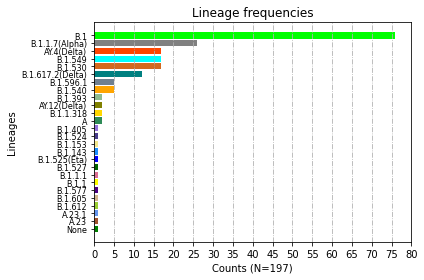

In [90]:
import math
# plot lineage frequencies
width = lins.sort_values(ascending=True)

colors = [lin_clrs[lin.split('(')[0]] for lin in list(width.index)]
# colors = [clr[1] for clr in clr_code.values()]
n = lins.sum()
xticks = np.arange(0, (math.ceil(max_count / 5) + 1) * 5, 5)
fig, ax = plt.subplots()
# (df_report_fnl['Pango Lineage Annotation']
#  .value_counts()
#  .sort_values(ascending=False)
plt.barh(width.index, width, color=colors)
plt.title('Lineage frequencies')
plt.ylabel('Lineages')
plt.xticks(xticks, xticks)
plt.yticks(width.index, fontsize=8)
plt.xlabel(f'Counts (N={n})')
plt.grid('major', axis='x', ls='-.')
plt.tight_layout()
# fig.savefig('/home/douso/SarsGenomics/Processed/policy-brief-P007h.png')
plt.show()

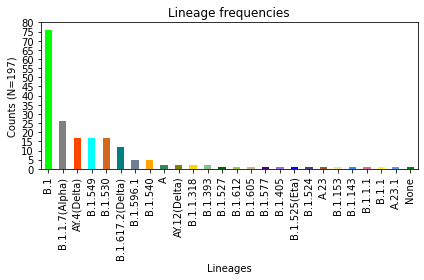

In [92]:
import math
# plot lineage frequencies
width = lins.sort_values(ascending=False)

colors = [lin_clrs[lin.split('(')[0]] for lin in list(width.index)]
n = df_report_fnl['Pango Lineage Annotation'].count()
yticks = np.arange(0, (math.ceil(max_count / 5) + 1) * 5, 5)
fig, ax = plt.subplots()
# (df_report_fnl['Pango Lineage Annotation']
#  .value_counts().
width.plot(kind='bar', ax=ax, color=colors)
plt.title('Lineage frequencies')
plt.xlabel('Lineages')
plt.yticks(yticks)
plt.xticks(ticks=range(len(lins)), rotation=90, labels=width.index)
plt.ylabel(f'Counts (N={n})')
plt.tight_layout()
# fig.savefig('/home/douso/SarsGenomics/Processed/policy-brief-P007.png', dpi=300.0)
plt.show()